In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

from utils import build_some_features
import pmdarima as pm
from pmdarima.pipeline import Pipeline


plt.rcParams['figure.figsize'] = (16, 4)

In [36]:
def date_to_datetime(data):
    data.time = pd.to_datetime(data.time, infer_datetime_format=True)

    data = data.set_index('time', drop=True)  

    return data    

In [2]:
#!pip install pmdarima

You should consider upgrading via the 'c:\users\amilas\miniconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv("data/data_v1.csv")
#data = pd.read_csv("data/data_v2.csv")

In [229]:
data.head()

,time,price,exog
0,2017-11-27 00:00:00,55.78,3889.0
1,2017-11-27 01:00:00,54.15,3565.0
2,2017-11-27 02:00:00,53.89,3186.0
3,2017-11-27 03:00:00,53.89,2752.0
4,2017-11-27 04:00:00,56.71,2435.0


In [3]:
data.time = pd.to_datetime(data.time, infer_datetime_format=True)

data = data.set_index('time',    # <---- Set the index to be our timestamp data  
                      drop=True)      # <---- drop the original column

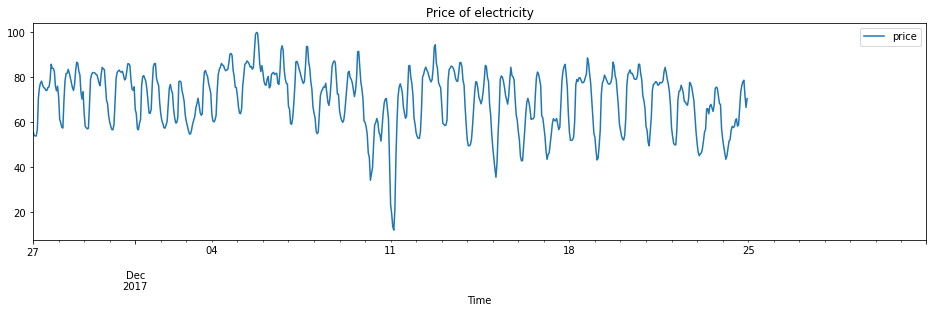

In [4]:
data[["price"]].plot()
plt.xlabel('Time')
plt.title('Price of electricity')
plt.show()

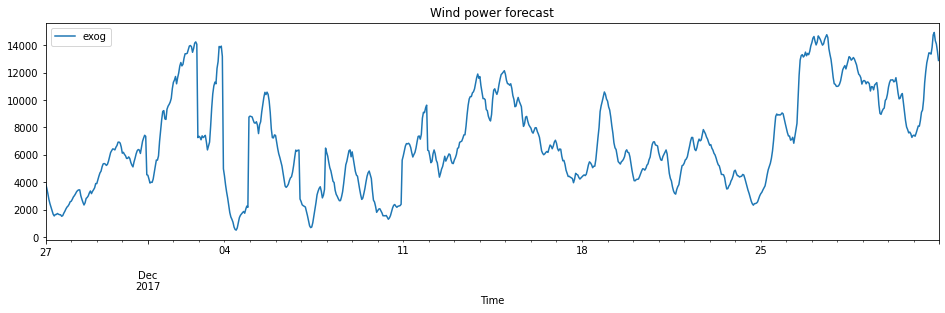

In [290]:
data[["exog"]].plot()
plt.xlabel('Time')
plt.title('Wind power forecast')
plt.show()

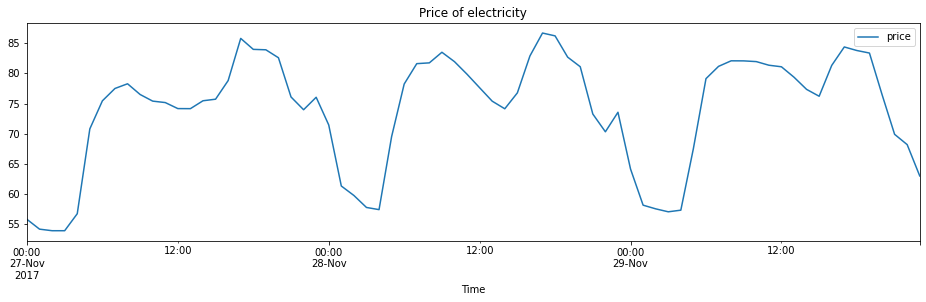

In [235]:
#check for seasonality
#plot three days
data[["price"]][0:72].plot()
plt.xlabel('Time')
plt.title('Price of electricity')
plt.show()

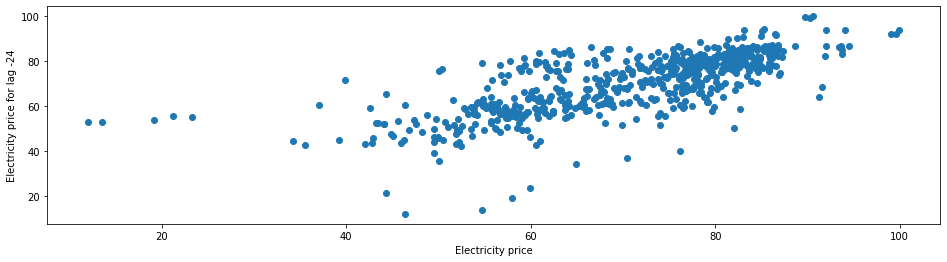

In [7]:
#check lag of 24 hours
#data = data.to_frame()
data['lag_24'] = data['price'].shift(-24)

plt.scatter(data['price'], data.lag_24)
plt.ylabel('Electricity price for lag -24')
plt.xlabel('Electricity price')
plt.show()

In [333]:
#check for correlations
data.corr()['price']

price     1.000000
exog     -0.201387
lag_24    0.825182
Name: price, dtype: float64

In [8]:
data_to_model = data.drop(["lag_24", "exog"], axis=1).dropna()

In [9]:
#decompose using additive model because variance doesnt vary with time
decomposition = seasonal_decompose(data_to_model, model='additive')


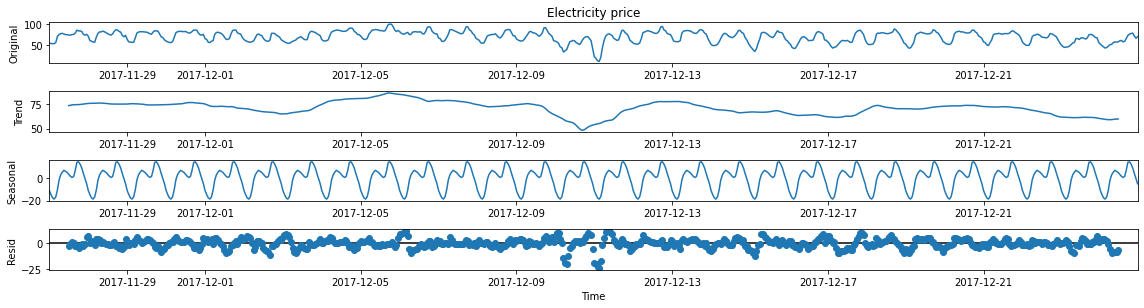

In [10]:
fig = decomposition.plot()
fig.axes[0].set_title('Electricity price')
fig.axes[0].set_ylabel('Original')
fig.axes[3].set_xlabel('Time')
plt.show()

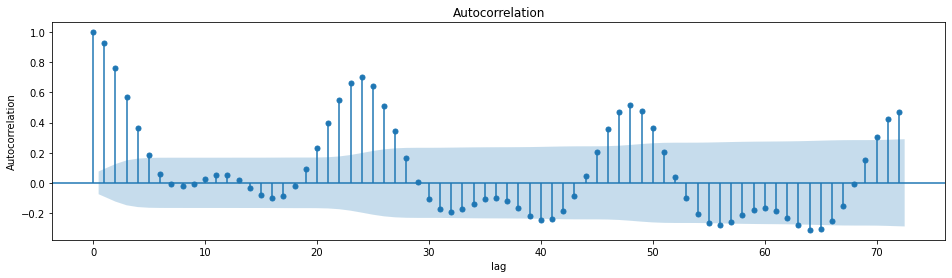

In [224]:
plot_acf(data_to_model, alpha=.05, lags=72)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

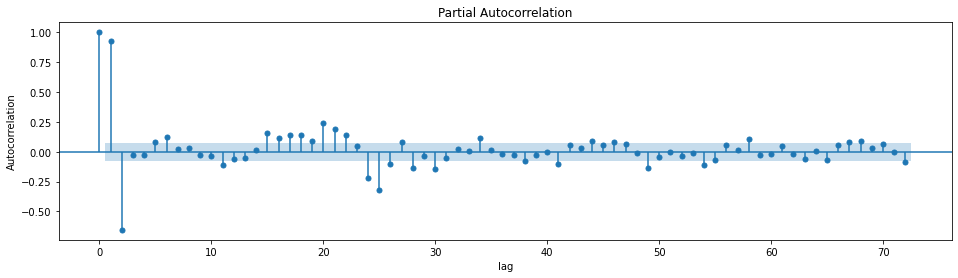

In [139]:
plot_pacf(data_to_model, alpha=0.05, lags=72)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [140]:
#check if data is stationary
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model)
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -1.89
pvalue:    0.339


In [12]:
data_to_model_logged = np.log(data_to_model)
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model_logged)
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -2.35
pvalue:    0.155


In [142]:
data_to_model_logged_diff = data_to_model_logged.diff()
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(data_to_model_logged_diff.dropna())
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -12.85
pvalue:    0.000


In [313]:
len(data_to_model)*0.2

134.4

In [13]:
#train = data_to_model_logged[:-134]
#test = data_to_model_logged[-134:]

train = data_to_model_logged[:-168]
test = data_to_model_logged[-168:]

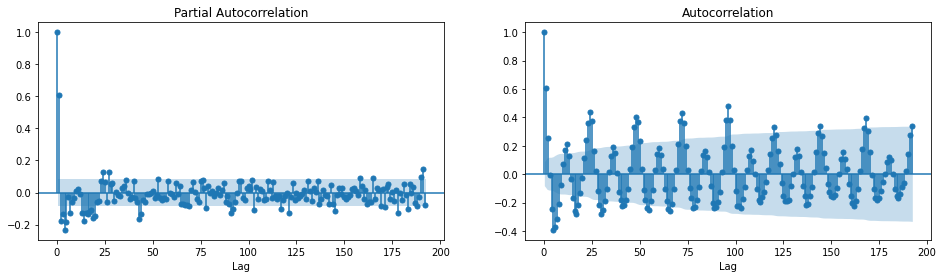

In [227]:
fig, ax = plt.subplots(1,2)
plot_pacf(train.diff().dropna(), alpha=.05, lags=24*8, ax=ax[0], method='ols') 
plot_acf(train.diff().dropna(), alpha=.05, lags=24*8, ax=ax[1])
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag')
plt.show()

In [14]:
# sets up the SARIMAX model
sarimax_c = SARIMAX(train, trend='c',        
                         order=(2, 1, 1),              # <-- keeping same parameters as before
                         #order=(5, 1, 0),
                         seasonal_order=(2, 0, 2, 24)) # <-- we'll get into how we found these hyper parameters later
                         #seasonal_order=(1, 0, 1, 24))



# trains the SARIMAX model
sarimax_results = sarimax_c.fit(maxiter=1000)

# predictions
sarimax_predictions = np.exp(sarimax_results.predict())[134:] # grab the prediction from our model and undo the log transform using exp

/home/ana/.virtualenvs/hckt03/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/ana/.virtualenvs/hckt03/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/ana/.virtualenvs/hckt03/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


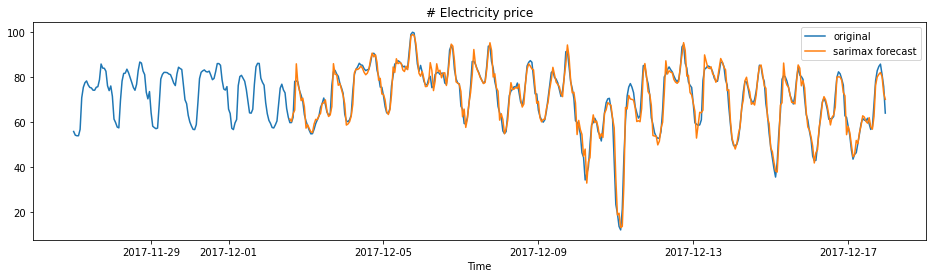

In [15]:
plt.plot(np.exp(train), label='original')
plt.plot(sarimax_predictions, label='sarimax forecast')
plt.xlabel('Time')
plt.title('# Electricity price')
plt.legend()
plt.show()

In [16]:
sarimax_forecast = sarimax_results.get_forecast(168)

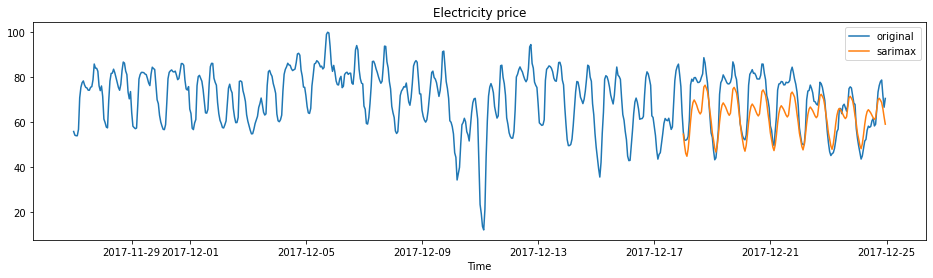

In [17]:
plt.plot(data_to_model, label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

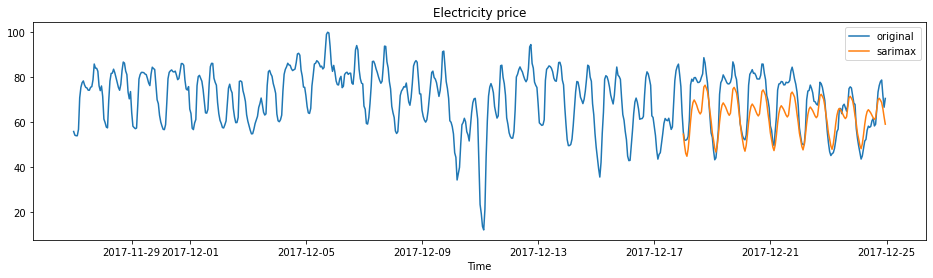

In [18]:
plt.plot(data_to_model, label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

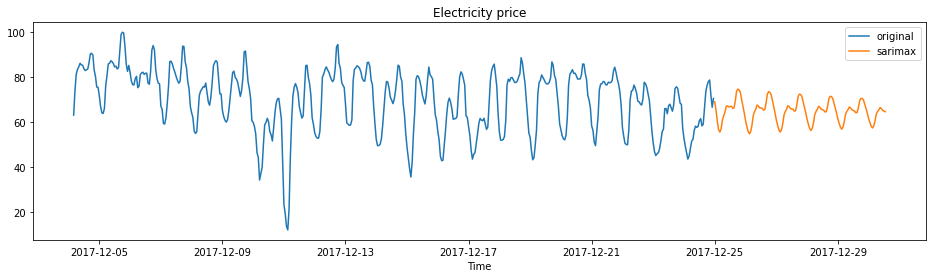

In [149]:
plt.plot(data_to_model[-500:], label='original')
plt.plot(np.exp(sarimax_forecast.predicted_mean), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [19]:
mean_absolute_error(np.exp(sarimax_forecast.predicted_mean),np.exp(test))

7.250205232462068

In [186]:
mean_absolute_error(np.exp(sarimax_forecast.predicted_mean),np.exp(test))

5.596337022537304

In [178]:
##finding the best parameters for SARIMAX
sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=24)
sarimax.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=8.61 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-1045.781, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-1321.685, Time=1.74 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-1282.593, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-1047.750, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=-1289.461, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=-1339.799, Time=11.64 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=18.38 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.71 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=-1202.979, Time=8.08 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=-1346.887, Time=15.18 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=-1329.490, Time=3.87 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=27.26 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(3,1,0)(2,0,0)[24] interc

AutoARIMA(m=24, trace=True)

In [188]:
sarimax_forecast = sarimax.predict(134)
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test))

13.239566138646774

In [190]:
len(test)

134

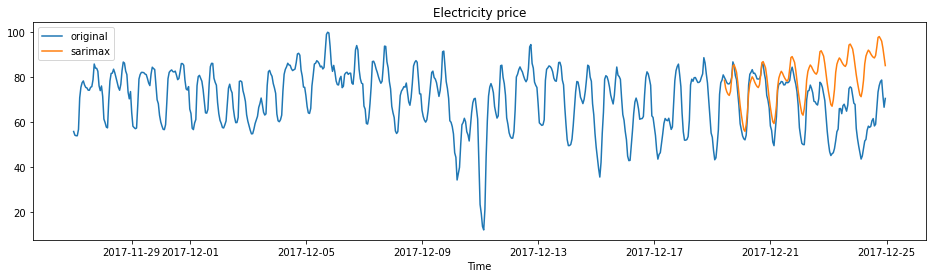

In [191]:
plt.plot(data_to_model, label='original')
plt.plot(test.index, np.exp(sarimax_forecast), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [166]:
print(len(train), len(test))

538 134


In [42]:
#adding exogenus data
data = pd.read_csv("data/data_v2.csv")
data = date_to_datetime(data)
test_split_date = '2017-12-18'
train_start_date = '2017-11-18'

train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date].dropna()

exog_train = train.drop(["price"], axis=1)
exog_test = test.drop(["price"], axis=1)

train=np.log(train.drop(["exog"], axis=1))
test=np.log(test.drop(["exog"], axis=1))

In [43]:
print(len(exog_train), len(exog_test))

720 168


In [44]:
exog_train

,exog
time,
2017-11-18 00:00:00,4429.0
2017-11-18 01:00:00,4585.0
2017-11-18 02:00:00,4736.0
2017-11-18 03:00:00,4889.0
2017-11-18 04:00:00,5146.0
...,...
2017-12-17 19:00:00,4571.0
2017-12-17 20:00:00,4533.0
2017-12-17 21:00:00,4351.0


In [51]:
train

,price
time,
2017-11-18 00:00:00,4.120986
2017-11-18 01:00:00,4.060960
2017-11-18 02:00:00,4.036539
2017-11-18 03:00:00,4.006969
2017-11-18 04:00:00,4.011687
...,...
2017-12-17 19:00:00,4.439470
2017-12-17 20:00:00,4.451669
2017-12-17 21:00:00,4.395683


In [52]:
sarimax_pipeline_exog = Pipeline([ 
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm',
                           maxiter=20,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(train,exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=275.432, Time=4.54 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=2390.175, Time=0.29 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-26.829, Time=3.38 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=2392.710, Time=3.46 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=3141.156, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-378.546, Time=0.29 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-26.903, Time=3.34 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=64.328, Time=2.78 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=-271.825, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-264.977, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=2514.681, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=-108.656, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,0,0)(0,0,0)[24] intercept
Total fit time: 20.093 seconds


Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm', trace=True))])

In [47]:
sarimax_pipeline_exog.predict(168,exog_test)

array([4.13554557, 4.11530117, 4.09568812, 4.08480716, 4.062629  ,
       4.02364804, 3.9815452 , 3.9500014 , 3.94178033, 3.93822873,
       3.94079718, 3.9189078 , 3.90527524, 3.85449226, 3.77901692,
       3.70575444, 3.63753144, 3.53566751, 3.49036044, 3.45390992,
       3.41423679, 3.37699603, 3.37796008, 3.39251364, 3.39206654,
       3.41262059, 3.41870602, 3.44609538, 3.48400913, 3.51394727,
       3.55715875, 3.57389325, 3.57255776, 3.59672185, 3.61886564,
       3.61582641, 3.61198723, 3.58884824, 3.57339154, 3.55422623,
       3.53012799, 3.49176984, 3.47324287, 3.4779092 , 3.47068156,
       3.48374005, 3.51219132, 3.54196917, 3.56405249, 3.58126841,
       3.57305337, 3.55721681, 3.54774616, 3.5377607 , 3.51648127,
       3.49162725, 3.46831906, 3.44762582, 3.44070674, 3.43938169,
       3.42148198, 3.396103  , 3.38120719, 3.35049814, 3.32851217,
       3.28260835, 3.24275029, 3.22193189, 3.21418986, 3.22472124,
       3.21966208, 3.21674562, 3.24547689, 3.26113749, 3.27351

In [48]:
sarimax_forecast_exog = sarimax_pipeline_exog.predict(168,exog_test)
mean_absolute_error(np.exp(sarimax_forecast_exog),np.exp(test))

39.652857617553884

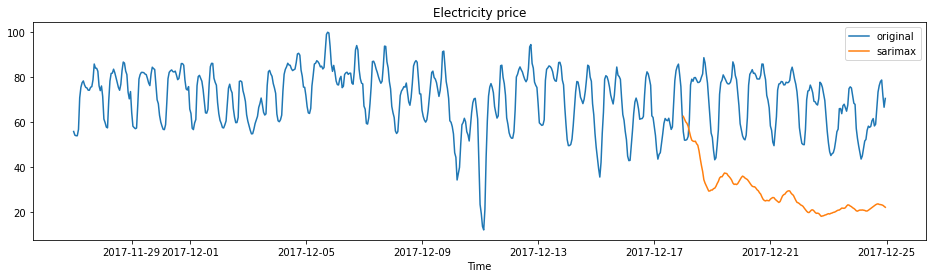

In [49]:
plt.plot(data_to_model, label='original')
plt.plot(test.index, np.exp(sarimax_forecast_exog), label='sarimax')
plt.xlabel('Time')
plt.title('Electricity price')
plt.legend()
plt.show()

In [76]:
#train_all = data_to_model
data_v2 = pd.read_csv("data/data_v2.csv")
data_v2.time = pd.to_datetime(data_v2.time, infer_datetime_format=True)

data_v2 = data_v2.set_index('time',    # <---- Set the index to be our timestamp data  
                      drop=True)      # <---- drop the original column

In [112]:
#train_all = data_to_model
data_v1 = pd.read_csv("data/data_v1.csv")
data_v1.time = pd.to_datetime(data_v1.time, infer_datetime_format=True)

data_v1 = data_v1.set_index('time',    # <---- Set the index to be our timestamp data  
                      drop=True)    

In [113]:
train_all = data_v1.drop(["exog"], axis=1).dropna()

In [115]:
train_all = np.log(train_all)

In [116]:
train_all

,price
time,
2017-11-27 00:00:00,4.021415
2017-11-27 01:00:00,3.991758
2017-11-27 02:00:00,3.986945
2017-11-27 03:00:00,3.986945
2017-11-27 04:00:00,4.037951
...,...
2017-12-24 19:00:00,4.356581
2017-12-24 20:00:00,4.365516
2017-12-24 21:00:00,4.274859


In [117]:
# sets up the SARIMAX model
sarimax_c = SARIMAX(train_all, trend='c',        
                         order=(2, 1, 1),              # <-- keeping same parameters as before
                         seasonal_order=(2, 0, 2, 12)) # <-- we'll get into how we found these hyper parameters later

# trains the SARIMAX model
sarimax_results = sarimax_c.fit(maxiter=1000)



C:\Users\amilas\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\amilas\Miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [118]:
# predictions
sarimax_forecast_c = sarimax_results.get_forecast(168)
#mean_absolute_error(np.exp(sarimax_forecast_c.predicted_mean),np.exp(test))

In [119]:
predictions = sarimax_forecast_c.predicted_mean.values
predictions = np.exp(predictions)

In [102]:
pd.read_csv("data/sample_submission.csv")

,price
0,0.763691
1,0.512687
2,-0.896477
3,-0.253675
4,0.488613
...,...
163,1.789514
164,-2.079594
165,-0.673894
166,1.258650


In [122]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("sarimax_no_exogenus_v1", index=False)
#submission.to_csv("sarimax_no_exogenus_v2", index=False)

In [123]:
pd.read_csv("sarimax_no_exogenus_v1") #--> mse at the portal = 15.7, ARIMA(2,1,1)(2,0,2)[12] intercept

,price
0,69.026096
1,65.192074
2,60.316324
3,56.501876
4,55.516956
...,...
163,69.000458
164,68.484049
165,66.997739
166,65.412979


In [ ]:
pd.read_csv("sarimax_no_exogenus_v2") #--> mse at the portal = 33, ARIMA(2,1,2)(2,0,2)[12] intercept

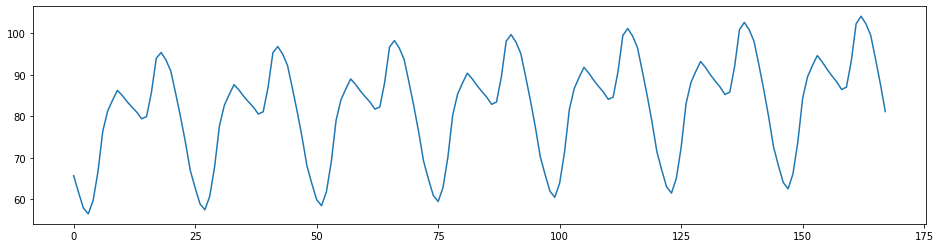

In [111]:
plt.plot(predictions)


In [208]:
build_some_features(data, "price", num_periods_lagged=0, num_periods_diffed=0, weekday=True, month=True, rolling=[], holidays=True)

,price,exog,lag_24,sin_weekday,cos_weekday,sin_month,cos_month,holidays
time,,,,,,,,
2017-11-27 00:00:00,55.78,3889.0,71.44,0.000000,1.00000,-5.000000e-01,0.866025,0.0
2017-11-27 01:00:00,54.15,3565.0,61.31,0.000000,1.00000,-5.000000e-01,0.866025,0.0
2017-11-27 02:00:00,53.89,3186.0,59.74,0.000000,1.00000,-5.000000e-01,0.866025,0.0
2017-11-27 03:00:00,53.89,2752.0,57.75,0.000000,1.00000,-5.000000e-01,0.866025,0.0
2017-11-27 04:00:00,56.71,2435.0,57.39,0.000000,1.00000,-5.000000e-01,0.866025,0.0
...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,NaN,14922.0,NaN,-0.781831,0.62349,-2.449294e-16,1.000000,0.0
2017-12-31 20:00:00,NaN,14321.0,NaN,-0.781831,0.62349,-2.449294e-16,1.000000,0.0
2017-12-31 21:00:00,NaN,14087.0,NaN,-0.781831,0.62349,-2.449294e-16,1.000000,0.0
